I removed an assertion at: c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\torchdiffeq\_impl\misc.py

at line 215

In [1]:
import torch as t
from torchdiffeq import odeint_adjoint as odeint

import matplotlib.pyplot as plt

In [2]:
times2 = t.linspace(0,30,1000)

y0 = t.eye(2).cfloat().flatten()

def Ht(time):
    # return t.cos(2*t.pi/10*time)*t.tensor([[0,1],[1,0]]).cfloat()
    return 1/t.sqrt(t.tensor(2))*(t.tensor([[0,1],[1,0]]).cfloat() + t.tensor([[0,-1j],[1j,0]]))

In [59]:
class Lambda(t.nn.Module):
    def forward(self, time, y):
        B0 = 0.9949634671211243
        U = y.view(2,2)
        H = B0*Ht(time)
        return (-1j*H@U).flatten()

In [60]:
with t.no_grad():
    true_U = odeint(Lambda(),y0=y0,t=times2,method='scipy_solver',options={'solver':'RK45'})

In [61]:
occs2 = (true_U.view(-1,2,2)@t.tensor([1,0]).cfloat()).abs().square()

In [70]:
true_U.view(-1,2,2)[-1].abs().square().sum(0)

tensor([1.0000, 1.0000])

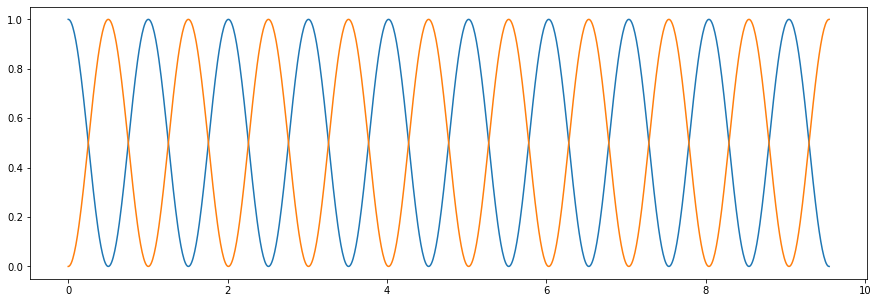

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(times/t.pi,occs[:,0],'b.')
# ax.plot(times/t.pi,occs[:,1],'r.')
ax.plot(times2/t.pi,occs2)
# ax.set_xlim(2.1220,2.1225)

In [13]:
help(odeint)

Help on function odeint_adjoint in module torchdiffeq._impl.adjoint:

odeint_adjoint(func, y0, t, *, rtol=1e-07, atol=1e-09, method=None, options=None, event_fn=None, adjoint_rtol=None, adjoint_atol=None, adjoint_method=None, adjoint_options=None, adjoint_params=None)



In [290]:
def Ht(time):
    # return t.cos(2*t.pi/10*time)*t.tensor([[0,1],[1,0]]).cfloat()
    return t.tensor([[0,1],[1,0]]).cfloat()
    # return 1/t.sqrt(t.tensor(2))*(t.tensor([[0,1],[1,0]]).cfloat() + t.tensor([[0,-1j],[1j,0]]))

class ODEFunc(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.B0 = t.nn.parameter.Parameter(t.tensor(1.0))
    
    def forward(self, time, y):
        U = y.view(2,2)
        H = self.B0*Ht(time)
        return (-1j*H@U).flatten()
func = ODEFunc()

In [291]:
optimizer = t.optim.Adam(func.parameters(),lr=1e-2)

In [292]:
target_gate_adj = t.tensor([[0,1],[1,0]]).cfloat().adjoint()
def loss_func(U):
    return 1 - 0.25*t.square(t.abs(t.trace(target_gate_adj@U)))

weights = 1/(1+t.exp(times-25))
def loss_func2(Us):
    occs = (Us@t.tensor([1,0]).cfloat()).abs().square()*weights.view(-1,1)
    return 1 - occs[:,1].mean() + occs[:,0].mean()
    # return (1-occs[:,1]).square().mean()
    # return (occs[2:] -2*occs[1:-1] + occs[:-2]).abs().mean()
    # return t.mean((0.5 - occs[:,1])**(-10))

In [293]:
# torchdiffeq = importlib.reload(torchdiffeq)
B0s = []
losss = []
def train(Nepochs):
    for i in range(Nepochs):
        optimizer.zero_grad()
        pred_y = odeint(func,
                        y0=y0,
                        t=t.linspace(0,30,500),
                        rtol=1e-03,
                        atol=1e-06,
                        adjoint_rtol=None,
                        adjoint_atol=None,
                        method='scipy_solver',
                        options={'solver':'RK45'}, #BDF
                        adjoint_method="scipy_solver",
                        adjoint_options={'solver':'RK45'})
        # return pred_y
        U = pred_y.view(-1,2,2)
        loss = 0*loss_func(U[-1]) + loss_func2(U)
        loss.backward()
        optimizer.step()

        with t.no_grad():
            losss.append(loss.item())
            B0s.append(func.B0.item())
            print(f"loss: {loss.item()}, step: {i}", end='\r')

In [294]:
tmp = train(10)

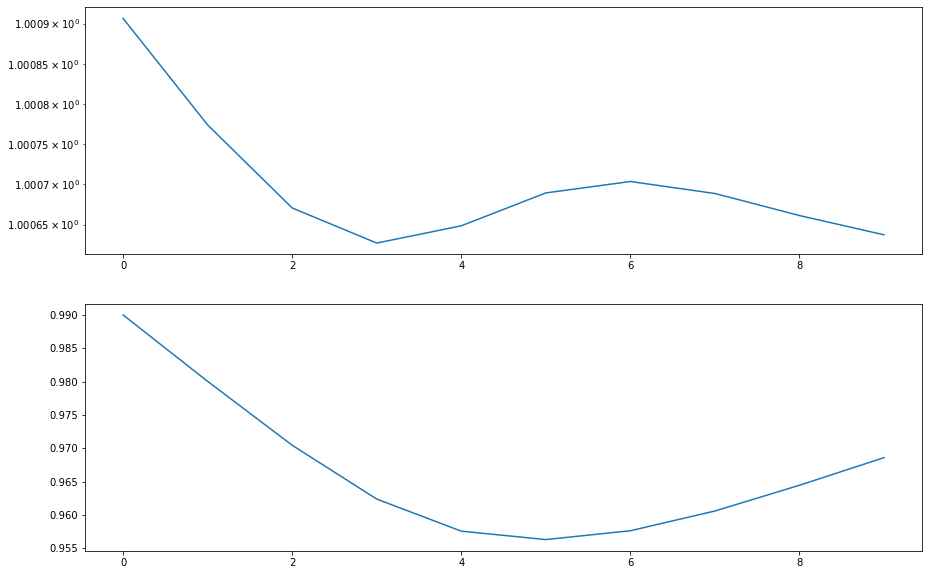

In [295]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2)
ax[0].plot(t.tensor(losss))
ax[0].set_yscale('log')
ax[1].plot(B0s)

In [299]:
times = t.linspace(0,30,500)
class Lambda(t.nn.Module):
    def forward(self, time, y):
        B0 = func.B0.item()
        U = y.view(2,2)
        H = B0*Ht(time)
        return (-1j*H@U).flatten()

with t.no_grad():
    true_U = odeint(Lambda(),y0=y0,t=times,method='scipy_solver',options={'solver':'RK45'})

occs = (true_U.view(-1,2,2)@t.tensor([1,0]).cfloat()).abs().square()

In [288]:
occs.shape

torch.Size([500, 2])

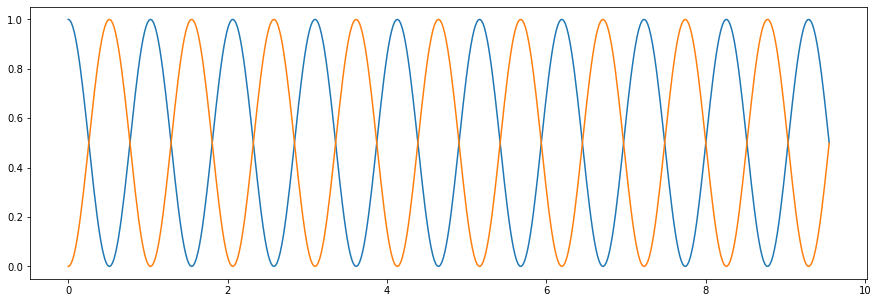

In [300]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(times/t.pi,occs)

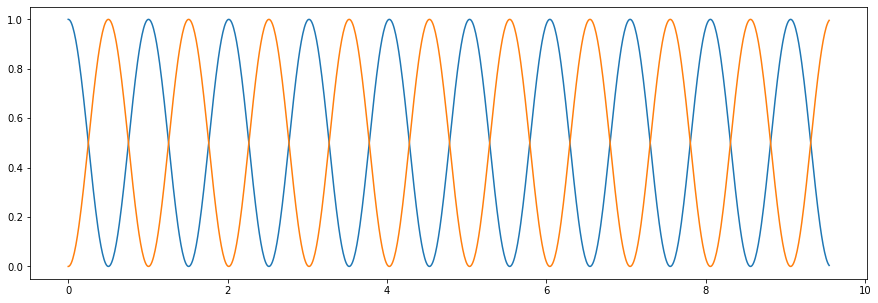

In [198]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(times/t.pi,occs)